<a href="https://colab.research.google.com/github/abdulrahman-hassanin/BERT_Spam_Detection/blob/main/BERT_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Spam Detection with BERT
This project aims to fine-tune BERT model to detect spam SMS using [SMS Spam Collection](https://www.kaggle.com/uciml/sms-spam-collection-dataset). The dataset consist of 5,574 English SMS which tagged accroding ham or spam.

In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.jso

kaggle.json
chmod: cannot access '/root/.kaggle/kaggle.jso': No such file or directory


In [3]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 76.8MB/s]


In [4]:
!unzip /content/sms-spam-collection-dataset.zip

Archive:  /content/sms-spam-collection-dataset.zip
  inflating: spam.csv                


#Import Dataset

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
df.shape

(5572, 5)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [9]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [10]:
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
class_dict = {
    'ham': 0,
    'spam':1
}

df['target'] = df['target'].map(class_dict)
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
df['text'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

# EDA

In [13]:
# duplicated values
df.duplicated().sum()

403

In [14]:
# drop duplicated values
df=df.drop_duplicates(keep='first')
df.duplicated().sum()

0

In [15]:
df['target'].value_counts(normalize=True)

0    0.87367
1    0.12633
Name: target, dtype: float64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


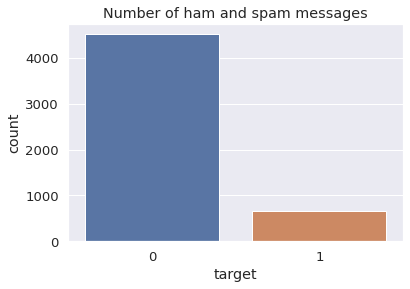

In [16]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(df.target).set_title("Number of ham and spam messages")
plt.show()

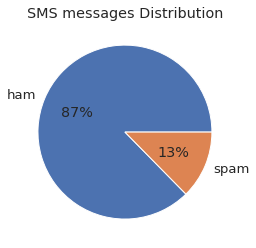

In [17]:
sms = pd.value_counts(df["target"], sort=True)
sms.plot(kind="pie", labels=["ham", "spam"], autopct="%1.0f%%")

plt.title("SMS messages Distribution")
plt.ylabel("")
plt.show()

In [18]:
df['length'] = df.text.apply(len)
df.head()

,target,text,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


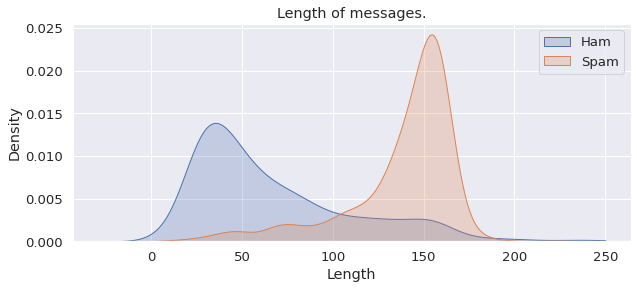

In [19]:
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(df.loc[df.target == 0, "length"], shade=True, label="Ham", clip=(-50, 250),)
sns.kdeplot(df.loc[df.target == 1, "length"], shade=True, label="Spam")
ax.set(
    xlabel="Length",
    ylabel="Density",
    title="Length of messages.",
)
ax.legend(loc="upper right")
plt.show()

# Text Pre-processing

In [20]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
stop_words = stopwords.words('english')
print(stop_words[::10])

porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [23]:
def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                   
    return " ".join(text)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

In [24]:
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(remove_stopwords)
df['text'] = df['text'].apply(stemmer)

df.head()

,target,text,length
0,0,go jurong point crazi avail bugi n great world...,111
1,0,ok lar joke wif u oni,29
2,1,free entri wkli comp win fa cup final tkt st m...,155
3,0,u dun say earli hor u c alreadi say,49
4,0,nah think goe usf live around though,61


In [25]:
print(df['text'].apply(lambda x: len(x.split(' '))).sum())

45463


In [26]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],df['target'], 
                                                    stratify=df['target'], 
                                                    test_size=0.3)

# BERT

In [27]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
weights = compute_class_weight(class_weight='balanced', 
                                 classes=np.unique(y_train), 
                                 y=y_train)

class_weight = {0: weights[0], 1: weights[1]}


print(class_weight)

{0: 0.5722872508699779, 1: 3.9584245076586435}


In [28]:
!pip install transformers

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [30]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [31]:
def bert_encode(input_text, max_len):
    tokens = tokenizer.batch_encode_plus(
        input_text.tolist(),
            add_special_tokens = True,
            truncation=True,
            max_length = max_len,
            padding = True,
            return_attention_mask = True,
    )
    return tf.convert_to_tensor(tokens['input_ids']), tf.convert_to_tensor(tokens['attention_mask'])


In [32]:
train_input_ids, train_attention_masks = bert_encode(X_train, 65)
test_input_ids, test_attention_masks = bert_encode(X_test, 65)

In [33]:
def create_model(bert_model):
    input_ids = tf.keras.Input(shape= (65,), dtype= 'int32')
    attention_masks = tf.keras.Input(shape= (65,), dtype= 'int32')
    
    output = bert_model([input_ids, attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32, activation= 'relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1, activation= 'sigmoid')(output)
    
    model = tf.keras.models.Model(inputs= [input_ids, attention_masks], outputs= output)
    model.compile(Adam(learning_rate=1e-5), loss= 'binary_crossentropy', metrics= ['accuracy'])
    return model

In [34]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [35]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 65,                                            

In [36]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train, 
    epochs = 5,
    batch_size = 10,
    validation_data=([test_input_ids, test_attention_masks], y_test),
    class_weight=class_weight
)

Epoch 1/5
362/362 [==============================] - 129s 232ms/step - loss: 0.2868 - accuracy: 0.9262 - val_loss: 0.1940 - val_accuracy: 0.9407
Epoch 2/5
362/362 [==============================] - 71s 196ms/step - loss: 0.1253 - accuracy: 0.9732 - val_loss: 0.1595 - val_accuracy: 0.9516
Epoch 3/5
362/362 [==============================] - 69s 191ms/step - loss: 0.0689 - accuracy: 0.9873 - val_loss: 0.0809 - val_accuracy: 0.9807
Epoch 4/5
362/362 [==============================] - 68s 188ms/step - loss: 0.0525 - accuracy: 0.9900 - val_loss: 0.1831 - val_accuracy: 0.9542
Epoch 5/5
362/362 [==============================] - 69s 190ms/step - loss: 0.0310 - accuracy: 0.9939 - val_loss: 0.1020 - val_accuracy: 0.9781


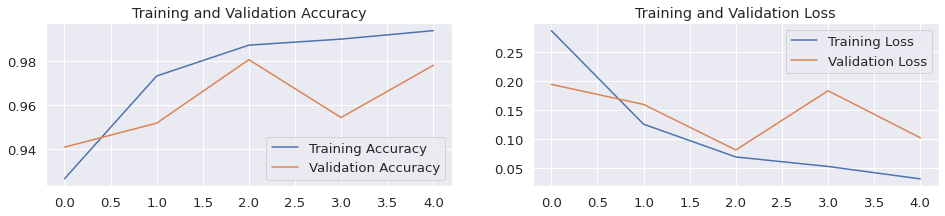

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(16, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
# plt.savefig('graph4_97_final.jpg')
plt.show()

# Model Prediction

In [38]:
y_predicted = model.predict([test_input_ids, test_attention_masks])
y_predicted = y_predicted.flatten()

49/49 [==============================] - 11s 143ms/step


In [39]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[1333,   22],
       [  12,  184]])

Text(63.5, 0.5, 'Truth')

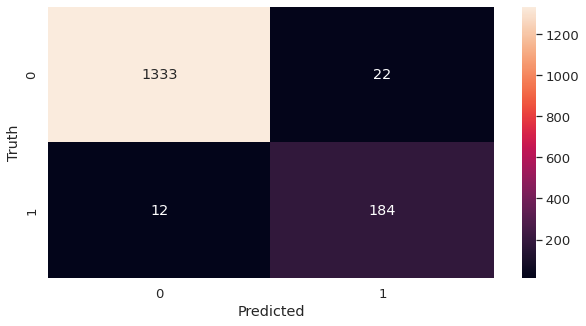

In [41]:
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [42]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1355
           1       0.89      0.94      0.92       196

    accuracy                           0.98      1551
   macro avg       0.94      0.96      0.95      1551
weighted avg       0.98      0.98      0.98      1551

